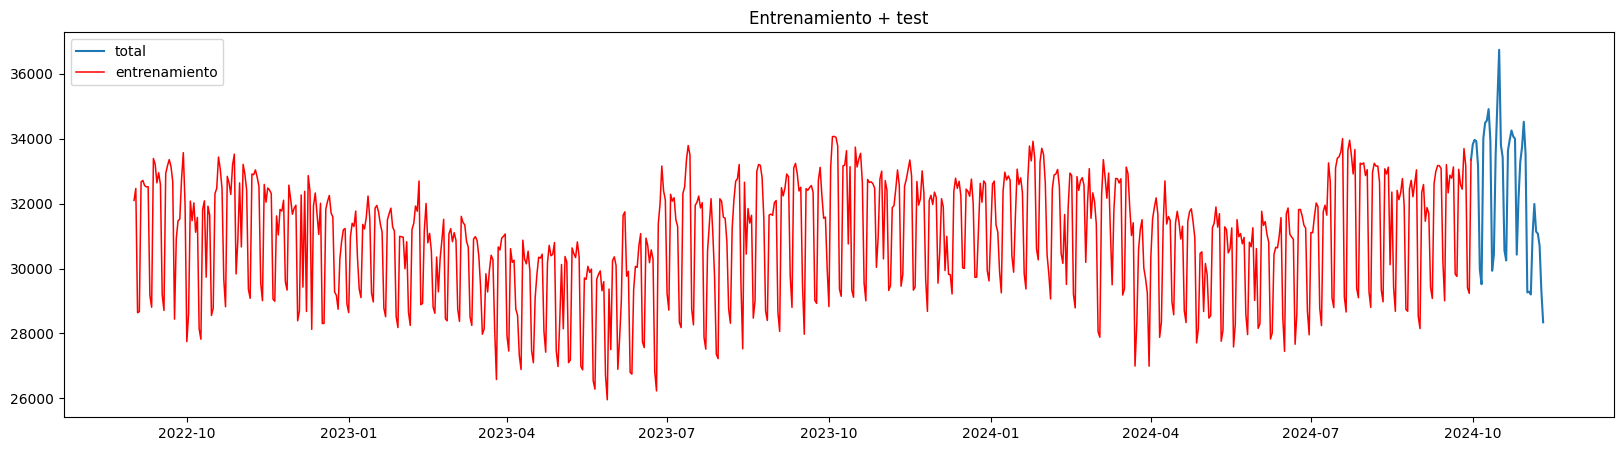

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = pd.read_csv('../data/consumo-energetico-2023.csv') # 2023 empieza en enero y termina en diciembre

def daily(df):
    grouped = df.groupby('fecha')['consumo'].sum().reset_index()
    
    if len(grouped) > 1 and grouped.iloc[-1, 1] < 0.5 * grouped.iloc[-2, 1]:
        grouped = grouped.iloc[:-1]  # Remove last two entries if the last value is too low

    return grouped.rename(columns={'fecha': 'date', 'consumo': 'value'})

timeseries = daily(df)

def daily(df):
    grouped = df.groupby('fecha')['consumo'].sum().reset_index()
    if len(grouped) > 1 and grouped.iloc[-1, 1] < 0.5 * grouped.iloc[-2, 1]:
        grouped = grouped.iloc[:-1]  # Remove last entry if it's incomplete
    grouped = grouped.rename(columns={'fecha': 'date', 'consumo': 'value'})
    # Convert the date column to datetime
    grouped['date'] = pd.to_datetime(grouped['date'])
    return grouped

years = [2022, 2023, 2024]

total = pd.DataFrame()
for year in years:
    df = pd.read_csv(f'../data/consumo-energetico-{year}.csv')
    timeseries = daily(df)
    total = pd.concat([total, timeseries])

sept22_oct23 = total[:int(len(total['date'].values)-41)]

plt.figure(figsize=(20,5))
plt.title('Entrenamiento + test')
plt.plot(total['date'].values[int(len(total['date'].values)-41-1):], total['value'].values[int(len(total['date'].values)-41-1):], label = 'total')
plt.plot(sept22_oct23['date'].values, sept22_oct23['value'].values, label = 'entrenamiento', color = 'r', linewidth = 1.1)
plt.legend()
plt.show()

In [31]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from src.utils import metrics

# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Ensures reproducibility for multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  

In [54]:
np.array(total)[:,1].astype(np.float32)

array([32097.03, 32464.9 , 28637.52, 28672.48, 32666.27, 32713.83,
       32554.4 , 32515.69, 32519.22, 29166.14, 28808.35, 33388.93,
       33215.07, 32638.51, 32949.58, 32584.43, 29201.07, 28708.93,
       32924.89, 33163.5 , 33354.17, 33140.78, 32675.07, 28441.5 ,
       30919.47, 31467.37, 31521.56, 32750.57, 33569.33, 31965.72,
       27748.22, 28604.3 , 32076.81, 31473.14, 32021.1 , 31116.49,
       31574.  , 28141.14, 27822.63, 31822.07, 32084.78, 29733.22,
       31920.82, 31641.37, 28553.47, 28777.97, 32307.96, 32468.85,
       33433.39, 33060.7 , 32466.38, 29677.46, 28821.46, 32838.8 ,
       32629.56, 32282.19, 33187.05, 33521.82, 29832.4 , 30871.31,
       32637.08, 30665.  , 33207.92, 32907.96, 32416.08, 29364.03,
       29082.7 , 32910.78, 32889.49, 33036.34, 32812.6 , 32528.22,
       29547.91, 29007.91, 32590.64, 32042.7 , 32477.87, 32418.01,
       32307.71, 29055.88, 28993.19, 31620.2 , 31035.27, 31819.29,
       31768.82, 32102.52, 29593.09, 29335.06, 32566.91, 32147

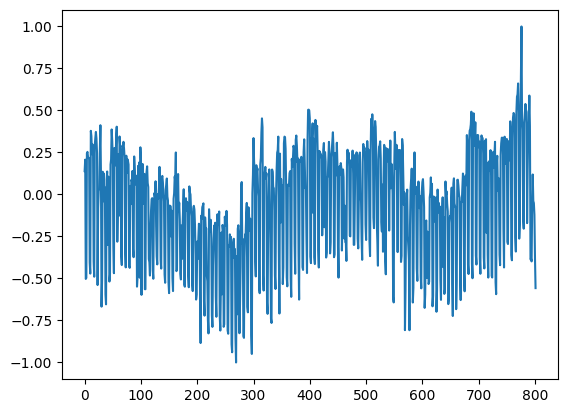

In [94]:
unnorm = np.array(total)[:,1].astype(np.float32)
days = len(total)

values = 2*(unnorm-unnorm.min())/(unnorm.max()-unnorm.min())-1
plt.plot(values)

In [96]:
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# ---------------------------
# Define Hyperparameter Grid
# ---------------------------
hyperparams = {
    'hidden_size': [16, 32, 64],
    'num_layers': [1, 2, 3],
    'dropout': [0.0, 0.1, 0.2],
    'learning_rate': [1e-3, 1e-2, 1e-1]
}

best_model_state = None
best_val_loss = float('inf')
best_hyperparams = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_and_evaluate(params):
    global best_model_state, best_val_loss, best_hyperparams
    
    # Initialize model with given hyperparameters
    model = LSTMModel(hidden_size=params['hidden_size'],
                      num_layers=params['num_layers'],
                      dropout=params['dropout'],
                      bidirectional=True).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    
    epochs = 500
    val_loss_history = []
    
    for epoch in range(epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x_batch).squeeze(), y_batch)
            loss.backward()
            optimizer.step()
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                val_loss += criterion(model(x_batch).squeeze(), y_batch).item() * x_batch.size(0)
        val_loss /= len(val_loader.dataset)
        val_loss_history.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            best_hyperparams = params
    
# ---------------------
# Hyperparameter Search
# ---------------------
for params in itertools.product(*hyperparams.values()):
    param_dict = dict(zip(hyperparams.keys(), params))
    print(f"Testing {param_dict}")
    train_and_evaluate(param_dict)

# ---------------
# Load best model
# ---------------
if best_model_state:
    model = LSTMModel(**best_hyperparams, bidirectional=True).to(device)
    model.load_state_dict(best_model_state)
    print(f"Best Hyperparameters: {best_hyperparams} with Validation Loss: {best_val_loss:.4f}")


Testing {'hidden_size': 16, 'num_layers': 1, 'dropout': 0.0, 'learning_rate': 0.001}
Testing {'hidden_size': 16, 'num_layers': 1, 'dropout': 0.0, 'learning_rate': 0.01}
Testing {'hidden_size': 16, 'num_layers': 1, 'dropout': 0.0, 'learning_rate': 0.1}
Testing {'hidden_size': 16, 'num_layers': 1, 'dropout': 0.1, 'learning_rate': 0.001}
Testing {'hidden_size': 16, 'num_layers': 1, 'dropout': 0.1, 'learning_rate': 0.01}
Testing {'hidden_size': 16, 'num_layers': 1, 'dropout': 0.1, 'learning_rate': 0.1}
Testing {'hidden_size': 16, 'num_layers': 1, 'dropout': 0.2, 'learning_rate': 0.001}
Testing {'hidden_size': 16, 'num_layers': 1, 'dropout': 0.2, 'learning_rate': 0.01}
Testing {'hidden_size': 16, 'num_layers': 1, 'dropout': 0.2, 'learning_rate': 0.1}
Testing {'hidden_size': 16, 'num_layers': 2, 'dropout': 0.0, 'learning_rate': 0.001}
Testing {'hidden_size': 16, 'num_layers': 2, 'dropout': 0.0, 'learning_rate': 0.01}
Testing {'hidden_size': 16, 'num_layers': 2, 'dropout': 0.0, 'learning_rate

TypeError: LSTMModel.__init__() got an unexpected keyword argument 'learning_rate'

In [102]:
# ---------------
# Load best model
# ---------------
if best_model_state:
    model = LSTMModel(hidden_size=64, num_layers=1, dropout=0.0, bidirectional=True).to(device)
    model.load_state_dict(best_model_state)
    print(f"Best Hyperparameters: {best_hyperparams} with Validation Loss: {best_val_loss:.4f}")

Best Hyperparameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.0, 'learning_rate': 0.001} with Validation Loss: 0.0196


Epoch 100/1000 - Train Loss: 0.0181 - Val Loss: 0.0209
Epoch 200/1000 - Train Loss: 0.0153 - Val Loss: 0.0262
Epoch 300/1000 - Train Loss: 0.0129 - Val Loss: 0.0300
Epoch 400/1000 - Train Loss: 0.0067 - Val Loss: 0.0437
Epoch 500/1000 - Train Loss: 0.0035 - Val Loss: 0.0508
Epoch 600/1000 - Train Loss: 0.0006 - Val Loss: 0.0458
Epoch 700/1000 - Train Loss: 0.0004 - Val Loss: 0.0454
Epoch 800/1000 - Train Loss: 0.0003 - Val Loss: 0.0446
Epoch 900/1000 - Train Loss: 0.0002 - Val Loss: 0.0429
Epoch 1000/1000 - Train Loss: 0.0002 - Val Loss: 0.0437

Best model found at epoch 100 with validation loss: 0.0209


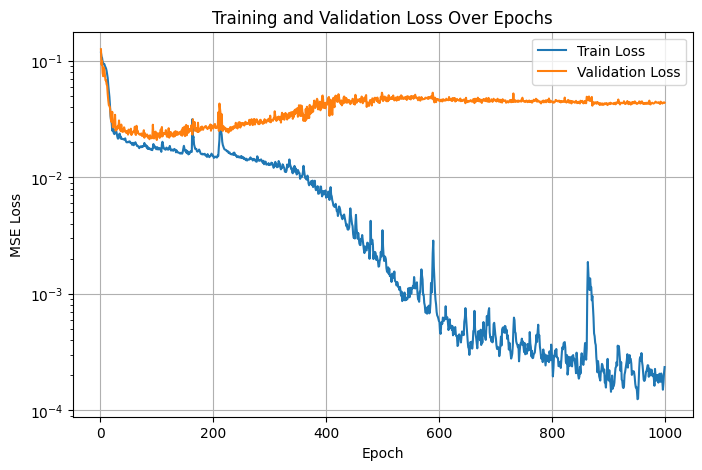

Metrics = {'MAE': 0.2726706707409556, 'MSE': 0.11423559919511861, 'RMSE': 0.33798757254538014, 'R2': 0.09562325477600098, 'MAPE': 312.2323826770427, 'sMAPE': 127.16956343578182}


In [104]:

# ---------------------------
# Train/Validation/Test Split
# ---------------------------
# Test: last 30% of the days
test_split = int(days * 0.7)
y_train = values[:test_split]
y_test = values[test_split:]

# Within the first 70%, use 80% for training and 20% for validation
val_split = int(len(y_train) * 0.8)
train_data = y_train[:val_split]
val_data = y_train[val_split:]

# -------------------------------------------------------
# Prepare PyTorch Dataset using a Sliding Window Approach
# -------------------------------------------------------
window_size = 30

class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size
        
    def __len__(self):
        return len(self.data) - self.window_size
    
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.window_size]
        y = self.data[idx + self.window_size]
        # Reshape x to (window_size, 1)
        return torch.tensor(x, dtype=torch.float32).unsqueeze(-1), torch.tensor(y, dtype=torch.float32)
        
train_dataset = TimeSeriesDataset(train_data, window_size)
val_dataset = TimeSeriesDataset(val_data, window_size)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ---------------------
# Define the LSTM Model
# ---------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size = 50, num_layers=1, dropout = 0.0, bidirectional = True):
        super(LSTMModel, self).__init__()

        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size, 
                            hidden_size, 
                            num_layers, 
                            dropout = dropout if num_layers > 1 else 0,
                            batch_first = True,
                            bidirectional = bidirectional)
        
        fnn_input_size = hidden_size * 2 if bidirectional else hidden_size 

        self.fc = nn.Linear(fnn_input_size, 1)
        
    def forward(self, x):
        # x shape: (batch, sequence_length, input_size)
        out, _ = self.lstm(x)
        # Use the output at the last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(hidden_size = 128, 
                  num_layers = 2,
                  dropout = 0.1, 
                  bidirectional = True
                  ).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), 
                       lr = 1e-3, )
                       #weight_decay = 1e-4) # weight_decay adds L2 regularization

# ------------------------------------------------------
# Training Loop with Validation and Best Model Selection
# ------------------------------------------------------
epochs = 1_000
train_loss_history = []
val_loss_history = []
best_val_loss = float('inf')
best_model_state = None
best_epoch = 0

for epoch in range(epochs):
    # Training Phase
    model.train()
    epoch_train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * x_batch.size(0)
        
    epoch_train_loss /= len(train_loader.dataset)
    train_loss_history.append(epoch_train_loss)
    
    # Validation Phase
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            epoch_val_loss += loss.item() * x_batch.size(0)
    epoch_val_loss /= len(val_loader.dataset)
    val_loss_history.append(epoch_val_loss)
    
    # Save the best model based on validation loss
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = model.state_dict()
        best_epoch = epoch + 1  # Store the epoch (1-based index)
        
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")
# -----------------------------------------
# Load the best model state for forecasting
# -----------------------------------------
if best_model_state is not None:
    model.load_state_dict(best_model_state)

print(f"\nBest model found at epoch {best_epoch} with validation loss: {best_val_loss:.4f}")

# ---------------------------------------------
# Plot Training and Validation Loss Over Epochs
# ---------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss_history, label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------------------
# Forecasting on Test Data (Recursive Multi-step Forecast)
# --------------------------------------------------------
model.eval()
y_pred = []
# Use the last window from the entire train+validation data as the starting point
last_window = y_train[-window_size:]
window = last_window.copy()

for i in range(len(y_test)):
    # Prepare input: shape (1, window_size, 1)
    input_seq = torch.tensor(window, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
    with torch.no_grad():
        pred = model(input_seq).item()
    y_pred.append(pred)
    # Update the window: slide by one, adding the new prediction
    window = np.append(window[1:], pred)

errors = metrics.all_metrics(y_true = y_test, y_pred = y_pred)
print(f'Metrics = {errors}')

In [91]:
from datetime import datetime

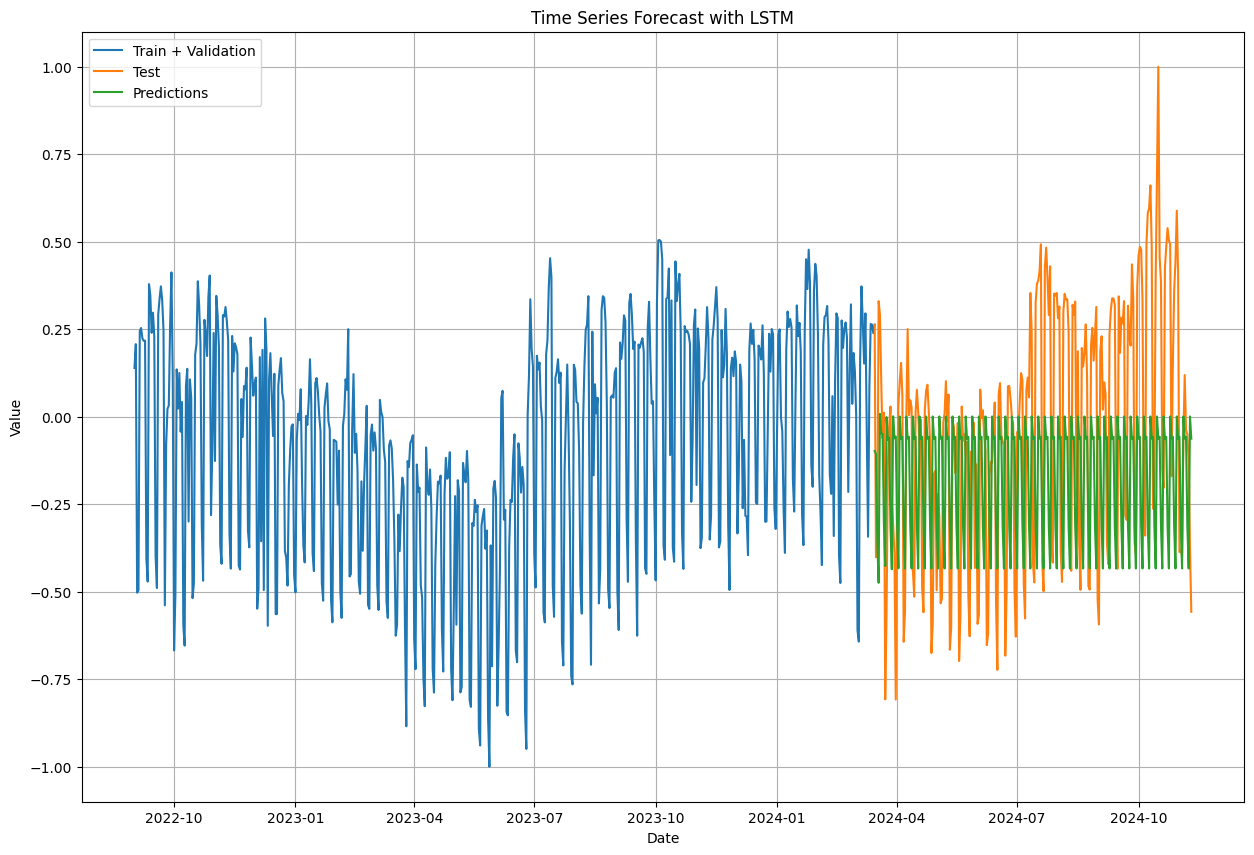

In [93]:
import matplotlib.pyplot as plt
import numpy as np

date = np.array(total)[:,0].astype(datetime)

# Create a figure with two subplots
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# ---------------------------
# Plot the Forecast Results
# ---------------------------
ax.plot(date[:test_split+1], values[:test_split+1], label='Train + Validation')
ax.plot(date[test_split:], y_test, label='Test')
ax.plot(date[test_split:], y_pred, label='Predictions')
ax.set_xlabel("Date")
ax.set_ylabel("Value")
ax.set_title("Time Series Forecast with LSTM")
ax.legend()
ax.grid()
plt.show()